In [151]:
# Load libraries
import re
import itertools
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, Bidirectional

import nltk
nltk.download("stopwords")

from collections import Counter
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkulagin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [152]:
mystem = Mystem() 
english_stopwords = stopwords.words("english")

def lemma_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in english_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

def preproc_text(array_text):
    new_array = []
    for text in array_text:
        new_text = lemma_text(text)
        new_array.append(new_text)
    return new_array

def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    for i in range(len(texts)):
        string = texts[i].split()
        for j in range(len(string)):
            if (string[j] in word2idx) and (j < max_text_len):
                data[i,j] = word2idx[string[j]]
    return data

# Data load and preprocessing text

In [3]:
data = pd.read_csv('../data/imdb_master.csv', encoding="ISO-8859-1")
data.head()

,id,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [4]:
data.label.value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

Text(0,0.5,'Количество примеров')

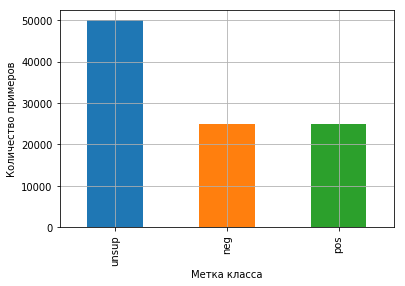

In [5]:
data.label.value_counts().plot.bar()
plt.grid(True)
plt.xlabel('Метка класса')
plt.ylabel('Количество примеров')

In [6]:
# Lemmatization and Stopwords
new_phrase = preproc_text(data.review.values)

In [115]:
new_phrase[0]

'mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky overconfident ashton kutcher problem comes kid thinks better anyone else around shows signs cluttered closet obstacle appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior inkling foreshadowing magic could keep turning hour'

Text(0,0.5,'Число строк')

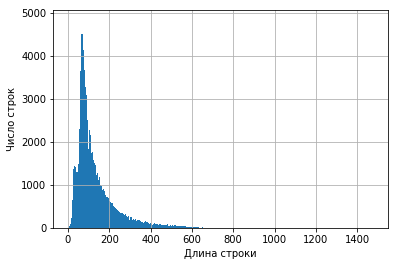

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(pd.Series(new_phrase).apply(lambda text: len(text.split())), bins='auto')
plt.grid(True)
plt.xlabel('Длина строки')
plt.ylabel('Число строк')

In [9]:
df = pd.concat([pd.Series(np.asarray(new_phrase)), data.label], axis=1)
df.columns = ['reviews', 'label']
df_for_train = df[df.label != 'unsup']
df_for_test = df[df.label == 'unsup']
df_for_train['label'][df_for_train.label == 'neg'] = 0
df_for_train['label'][df_for_train.label == 'pos'] = 1
df_for_train.label = df_for_train.label.astype(int)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(df_for_train.reviews, df_for_train.label, test_size=0.5)

In [156]:
X_train.shape, X_test.shape

((25000,), (25000,))

# Train model LR, kNN, NN in sklearn

In [ ]:
vecs = []
vecs.append(CountVectorizer(lowercase=True))
# vecs.append(TfidfVectorizer())
vecs.append(TfidfVectorizer(ngram_range=(1,4)))

clfs = []
clfs.append(LogisticRegression())
clfs.append(KNeighborsClassifier(n_neighbors=10))
clfs.append(MLPClassifier(activation='logistic', epsilon=1e-03, verbose=False))
for classifier in clfs:
    
    for vectorizer in vecs:
        
        pipeline = Pipeline([
            ('vec', vectorizer),
            ('clf', classifier)
        ])
    
        print('---------------------------------')
        print(str(classifier))
        print(str(vectorizer))
        
        acc = cross_val_score(pipeline, X_train.values, y_train.values, cv=5)
        print('Accuracy', np.mean(acc), np.std(acc))

        print('-----------------------------------')

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Accuracy 0.8821428112892118 0.0025750651527816667
-----------------------------------
---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='w

# CNN

In [157]:
#Create vocabulary
words_counter = Counter((word for text in X_train for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 100:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 4186


In [158]:
X_train_convert = convert(X_train.values, word2idx, 150)
X_test_convert = convert(X_test.values, word2idx, 150)

In [163]:
#Params general
# Embedding layer
output_embedd = 64
lenght_voc = len(word2idx)
input_embedd = X_train_convert.shape[1]

# First conv layer
filters = 128
kernel_size = 3
act_conv_1L = 'relu'
step = 1

# Second conv layer
filters2 = 64
kernel_size2 = 2
act_conv_2L = 'relu'
step2 = 2

# First dense layer
input_units_1L = 20
act_dens_1L = 'relu'

# Second dense layer
input_units_2L = 1
act_dens_2L = 'sigmoid'

# Compile model
loss_function = 'binary_crossentropy'
method_optim = 'adam'
list_metrics = ['accuracy']

In [164]:
model_cnn = Sequential([
        Embedding(input_dim=lenght_voc, output_dim=output_embedd, input_shape=(input_embedd,)),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=act_conv_1L, strides=step),
        Conv1D(filters=filters2, kernel_size=kernel_size2, activation=act_conv_2L, strides=step2),
        GlobalMaxPooling1D(),
        Dense(units=input_units_1L, activation=act_dens_1L),
        Dense(units=1, activation=act_dens_2L)
    ])

model_cnn.summary()
model_cnn.compile(loss=loss_function, optimizer=method_optim, metrics=list_metrics)
model_cnn.fit(X_train_convert, y_train, batch_size=256, epochs=5, 
              validation_data=(X_test_convert, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 64)           267904    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 148, 128)          24704     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 74, 64)            16448     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                1300      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 310,377
Trainable params: 310,377
Non-trainable params: 0
_________________________________________________________________
Trai

In [17]:
y_pred_test = model_cnn.predict_classes(X_test_convert)
print('Accuracy', accuracy_score(y_test.values, y_pred_test))
print('Recall', recall_score(y_test.values, y_pred_test))
print('Precision', precision_score(y_test.values, y_pred_test))
print('F1', f1_score(y_test.values, y_pred_test))  

Accuracy 0.8714666666666666
Recall 0.8682252922422954
Precision 0.8747323340471093
F1 0.8714666666666667


# RNN

In [ ]:
#Params general
# Embedding layer
output_embedd = 128
lenght_voc = len(word2idx)
input_embedd = X_train_convert.shape[1]

# First lstm layer
output_dim_1L = 64

# Second lstm layer
output_dim_2L = 32

# First dense layer
input_units_1L = 10
act_dens_1L = 'relu'

# Second dense layer
input_units_2L = 1
act_dens_2L = 'sigmoid'

# Compile model
loss_function = 'binary_crossentropy'
method_optim = 'adam'
list_metrics = ['accuracy']

In [ ]:
model_rnn = Sequential([
            Embedding(input_dim=lenght_voc, output_dim=output_embedd, input_shape=(input_embedd,)),
            Dropout(0.3),
            Bidirectional(LSTM(output_dim_1L, return_sequences=True)),
            LSTM(output_dim_2L),
            Dropout(0.5),
            Dense(units=input_units_1L, activation=act_dens_1L),
            Dense(units=input_units_2L, activation=act_dens_2L)
    ])

model_rnn.summary()
model_rnn.compile(loss=loss_function,
              optimizer=method_optim,
              metrics=list_metrics)
model_rnn.fit(X_train_convert, y_train, batch_size=128, epochs=20, 
              validation_data=(X_test_convert, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          692992    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total para

In [20]:
y_pred_test = model_rnn.predict_classes(X_test_convert)
print('Accuracy', accuracy_score(y_test.values, y_pred_test))
print('Recall', recall_score(y_test.values, y_pred_test))
print('Precision', precision_score(y_test.values, y_pred_test))
print('F1', f1_score(y_test.values, y_pred_test))  

Accuracy 0.6030666666666666
Recall 0.8480085253763154
Precision 0.5694605957599069
F1 0.6813657283527774


## Add new data

In [35]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data.review[data.label != 'unsup'].values)
unsup_data = data.review[data.label == 'unsup'].values
pos_data = data.review[data.label == 'pos'].values
neg_data = data.review[data.label == 'neg'].values

In [65]:
tf_unsup = tfidf_vectorizer.transform(unsup_data)
tf_pos = tfidf_vectorizer.transform(pos_data[np.random.randint(pos_data.shape[0], size=2000)])
tf_neg = tfidf_vectorizer.transform(neg_data[np.random.randint(neg_data.shape[0], size=2000)])
cos_pos = cosine_similarity(tf_pos, tf_unsup)
cos_neg = cosine_similarity(tf_neg, tf_unsup)
ave_pos = cos_pos.mean(axis=0)
ave_neg = cos_neg.mean(axis=0)
result = ave_pos > ave_neg
result = result.astype(int)

In [66]:
unsup_data_new = pd.concat([pd.Series(unsup_data), pd.Series(result)], axis=1)
pos_data_new = pd.concat([pd.Series(pos_data), pd.Series(np.ones(pos_data.shape[0]))], axis=1)
neg_data_new = pd.concat([pd.Series(neg_data), pd.Series(np.zeros(neg_data.shape[0]))], axis=1)
new_dataset = pd.concat([pos_data_new, neg_data_new, unsup_data_new])
new_dataset.columns = ['reviews', 'label']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(new_dataset.reviews, new_dataset.label, test_size=0.3)

In [97]:
#Create vocabulary
words_counter = Counter((word for text in X_train for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 100:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 9845


In [98]:
X_train_convert = convert(X_train.values, word2idx, 200)
X_test_convert = convert(X_test.values, word2idx, 200)

In [99]:
#Params general
# Embedding layer
lenght_voc = len(word2idx)
output_embedd = 64
input_embedd = X_train_convert.shape[1]

# First conv layer
filters = 128
kernel_size = 3
act_conv_1L = 'relu'
step = 2

# First dense layer
input_units_1L = 10
act_dens_1L = 'relu'

# Second dense layer
input_units_2L = 1
act_dens_2L = 'sigmoid'

# Compile model
loss_function = 'binary_crossentropy'
method_optim = 'adam'
list_metrics = ['accuracy']

In [100]:
model_cnn = Sequential([
        Embedding(input_dim=lenght_voc, output_dim=output_embedd, input_shape=(input_embedd,)),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=act_conv_1L, strides=step),
        GlobalMaxPooling1D(),
        Dense(units=input_units_1L, activation=act_dens_1L),
        Dense(units=1, activation=act_dens_2L)
    ])

model_cnn.summary()
model_cnn.compile(loss=loss_function, optimizer=method_optim, metrics=list_metrics)
model_cnn.fit(X_train_convert, y_train, batch_size=256, epochs=5, 
              validation_data=(X_test_convert, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           630080    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 99, 128)           24704     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 656,085
Trainable params: 656,085
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 30000 samples
Epoch 1/5
70000/70000 [==============================] - 83s 1ms/step - loss: 0.5260 -

## Word2Vec

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df_for_train.reviews, df_for_train.label, test_size=0.3)

In [132]:
X_new = X_train.apply(lambda x: x.split()).values

In [133]:
from gensim.models import Word2Vec

# train model
model = Word2Vec(X_new, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

Word2Vec(vocab=89513, size=100, alpha=0.025)
['weak', 'movie', 'mainly', 'poor', 'story', 'also', 'acting', 'case', 'robert', 'downey', 'jr', 'irrational', 'behaviour', 'many', 'characters', 'someone', 'likes', 'switch', 'mind', 'simply', 'watch', 'creativity', 'criteria', 'may', 'like', 'personally', 'drama', 'found', 'far', 'fetched', 'br', '/><', '/>', 'particularly', 'annoyed', 'main', 'character', 'supposed', 'intelligent', 'person', 'continually', 'acts', 'complete', 'imbecile', 'acted', 'way', 'would', 'normally', 'act', 'situations', 'first', 'highly', 'unlikely', 'successful', 'attorney', 'named', 'magruder', 'played', 'kenneth', 'branagh', 'leaving', 'party', 'happens', 'upon', 'girl', 'mallory', 'doss', 'embeth', 'davidtz', 'screaming', 'car', 'stolen', 'standing', 'around', 'tropical', 'rainstorm', 'badgers', 'accepting', 'ride', 'home', 'tells', 'weird', 'father', 'belongs', 'kind', 'sect', 'crazy', 'things', 'arrive', 'dilapidated', 'shack', 'poorer', 'part', 'town', 'not